# Organize all the observations you have into one dataset

In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import gsw
import datetime as dt

In [2]:
def umolkg_to_uM(umolkg, temp_in_situ, salinity_absolute, pressure):
    """
    Conver dissolved oxygen from µmol/kg to µM (µmol/L) using in-situ temperature, salinity, and pressure.
    
    Parameters:
    - temp_in_situ: In-situ temperature in degrees Celsius.
    - salinity_absolute: Absolute salinity in g/kg.
    - pressure: Pressure in dbar (default is 0, corresponding to surface).
    
    Returns:
    - Dissolved oxygen in µM (µmol/L).
    """
    # Calculate seawater density using TEOS-10
    conservative_temp = gsw.CT_from_t(salinity_absolute, temp_in_situ, pressure)
    density_seawater = gsw.rho(salinity_absolute, conservative_temp, pressure)  # Density in kg/m^3
    
    # Convert µmol/kg to µmol/L (µM) using the seawater density
    uM = umolkg * (density_seawater / 1000)  # density_seawater is in kg/m^3, so divide by 1000 to convert to L
    
    return uM


def oxygen_mlL_to_uM(oxygen_mlL, temp_in_situ, salinity_absolute, pressure):
    """
    Convert dissolved oxygen from mL/L to µM (µmol/L) using in-situ temperature, salinity, and pressure.
    
    Parameters:
    - oxygen_mlL: Dissolved oxygen in mL/L.
    - temp_in_situ: In-situ temperature in degrees Celsius.
    - salinity_absolute: Absolute salinity in g/kg.
    - pressure: Pressure in dbar (default is 0, corresponding to surface).
    
    Returns:
    - Dissolved oxygen in µM (µmol/L).
    """
    # Constants
    R = 0.0821  # Ideal gas constant in L·atm/(mol·K)
    P = (pressure / 10) + 1  # Convert dbar to atmospheres (1 atm at surface)
    T_kelvin = temp_in_situ + 273.15  # Convert temperature to Kelvin
    
    # Calculate molar volume of O2 under in-situ conditions (L/mol)
    molar_volume_O2_in_situ = R * T_kelvin / P
    
    # Convert mL/L to µmol/L using the in-situ molar volume
    oxygen_umolL = (oxygen_mlL * 1000) / molar_volume_O2_in_situ  # 1000 µmol in a mol
    
    return oxygen_umolL

In [3]:
# note: uM = umol/L
d = {'time':[],'source':[],'longitude (degrees_east)':[],'latitude (degrees_north)':[],'depth (m)':[],'pressure (dbar)':[],
    'temperature (degC)':[], 'salinity (g kg-1)':[], 'DO (uM)':[], 'NO3 (uM)':[], 'NO2 (uM)':[], 'NH4 (uM)':[], 'PO4 (uM)':[], 'SiO4 (uM)':[], 
    'Chl (mg m-3)':[], 'TA (uM)':[], 'DIC (uM)':[], 'Carbonate':[], 'Aragonite':[], 'Calcite':[], 'Al (nM)':[], 'Ba (nM)':[], 'Cd (nM)':[],
     'Co (nM)':[], 'Cu (nM)':[], 'Fe (nM)':[], 'Ga (nM)':[], 'Mn (nM)':[], 'Ni (nM)':[], 'Pb (nM)':[], 'Zn(nM)':[]}

ob = pd.DataFrame(d)

### IOS mooring

In [4]:
m2005 =pd.read_pickle('./observations/IOS_ctd_moor_2005.p')
m2010 =pd.read_pickle('./observations/IOS_ctd_moor_2010.p')
m2015 =pd.read_pickle('./observations/IOS_ctd_moor_2015.p')
m2020 =pd.read_pickle('./observations/IOS_ctd_moor_2020.p')
ios_moor = pd.concat([m2005,m2010,m2015,m2020])
ios_moor.head()

,longitude (degrees_east),latitude (degrees_north),sea_water_pressure (dbar),depth (m),sea_water_temperature (degC),sea_water_practical_salinity (PSS-78),DOXYZZ01 (mL/L),time
0,-123.424450,49.027150,13.177000,13.064797,9.5504,28.440600,NaN,2008-11-19 00:00:00+00:00
145,-126.203865,48.529617,40.143800,39.801180,NaN,32.426140,NaN,2009-05-24 00:00:00+00:00
146,-126.203865,48.529617,39.714828,39.375910,NaN,32.388807,NaN,2009-05-25 00:00:00+00:00
147,-126.203865,48.529617,39.632032,39.293829,NaN,32.367177,NaN,2009-05-26 00:00:00+00:00
148,-126.203865,48.529617,39.674800,39.336227,NaN,32.375100,NaN,2009-05-27 00:00:00+00:00


In [5]:
# convert to correct units
ios_moor['SA'] = gsw.conversions.SA_from_SP(ios_moor['sea_water_practical_salinity (PSS-78)'],ios_moor['sea_water_pressure (dbar)'],ios_moor['longitude (degrees_east)'],ios_moor['latitude (degrees_north)'])
ios_moor['DO'] = oxygen_mlL_to_uM(ios_moor['DOXYZZ01 (mL/L)'], ios_moor['sea_water_temperature (degC)'], ios_moor.SA, ios_moor['sea_water_pressure (dbar)'])

# add to the dataframe
temp = pd.DataFrame(d)

temp['time'] = pd.to_datetime(ios_moor.time)
temp['longitude (degrees_east)'] = ios_moor['longitude (degrees_east)']
temp['latitude (degrees_north)'] = ios_moor['latitude (degrees_north)']
temp['pressure (dbar)'] = ios_moor['sea_water_pressure (dbar)']
temp['depth (m)'] = ios_moor['depth (m)']
temp['temperature (degC)'] = ios_moor['sea_water_temperature (degC)']
temp['salinity (g kg-1)'] = ios_moor['SA']
temp['DO (uM)'] = ios_moor['DO']
temp['source'] ="ios mooring"

ob = pd.concat([ob, temp])


### IOS ctd profiles

In [6]:
p1965,p1967,p1969,p1971,p1973,p1975,p1977,p1979,p1981,p1983,p1985,p1987,p1989,p1991,p1993,p1995,p1997,p1999,p2001,p2003,p2005,p2007,p2009,p2011,p2013,p2015, p2017, p2018, p2019,p2020,p2021,p2022, p2023= pd.read_pickle('./observations/IOS_ctd_prof_1965.p'),pd.read_pickle('./observations/IOS_ctd_prof_1965.p'),pd.read_pickle('./observations/IOS_ctd_prof_1967.p'),pd.read_pickle('./observations/IOS_ctd_prof_1969.p'),pd.read_pickle('./observations/IOS_ctd_prof_1971.p'),pd.read_pickle('./observations/IOS_ctd_prof_1973.p'),pd.read_pickle('./observations/IOS_ctd_prof_1975.p'),pd.read_pickle('./observations/IOS_ctd_prof_1977.p'),pd.read_pickle('./observations/IOS_ctd_prof_1979.p'),pd.read_pickle('./observations/IOS_ctd_prof_1981.p'),pd.read_pickle('./observations/IOS_ctd_prof_1983.p'),pd.read_pickle('./observations/IOS_ctd_prof_1985.p'),pd.read_pickle('./observations/IOS_ctd_prof_1987.p'),pd.read_pickle('./observations/IOS_ctd_prof_1989.p'),pd.read_pickle('./observations/IOS_ctd_prof_1991.p'),pd.read_pickle('./observations/IOS_ctd_prof_1993.p'),pd.read_pickle('./observations/IOS_ctd_prof_1995.p'),pd.read_pickle('./observations/IOS_ctd_prof_1997.p'),pd.read_pickle('./observations/IOS_ctd_prof_1999.p'),pd.read_pickle('./observations/IOS_ctd_prof_2001.p'),pd.read_pickle('./observations/IOS_ctd_prof_2003.p'),pd.read_pickle('./observations/IOS_ctd_prof_2005.p'),pd.read_pickle('./observations/IOS_ctd_prof_2007.p'),pd.read_pickle('./observations/IOS_ctd_prof_2009.p'),pd.read_pickle('./observations/IOS_ctd_prof_2011.p'),pd.read_pickle('./observations/IOS_ctd_prof_2015.p'),pd.read_pickle('./observations/IOS_ctd_prof_2017.p'), pd.read_pickle('./observations/IOS_ctd_prof_2018.p'), pd.read_pickle('./observations/IOS_ctd_prof_2019.p'), pd.read_pickle('./observations/IOS_ctd_prof_2020.p'), pd.read_pickle('./observations/IOS_ctd_prof_2021.p'), pd.read_pickle('./observations/IOS_ctd_prof_2022.p'),pd.read_pickle('./observations/IOS_ctd_prof_2023.p')

ios_prof = pd.concat([p1965,p1967,p1969,p1971,p1973,p1975,p1977,p1979,p1981,p1983,p1985,p1987,p1989,p1991,p1993,p1995,p1997,p1999,p2001,p2003,p2005,p2007,p2009,p2011,p2013,p2015,p2017, p2018, p2019,p2020,p2021,p2022, p2023])
ios_prof.head()

,longitude (degrees_east),latitude (degrees_north),sea_water_pressure (dbar),depth (m),sea_water_temperature (degC),sea_water_practical_salinity (PSS-78),DOXYZZ01 (mL/L),time
0,-127.726670,51.958332,3.458870,3.428571,NaN,29.642576,NaN,1966-05-17 00:00:00+00:00
1,-127.668335,52.021667,3.458890,3.428571,NaN,25.343174,NaN,1966-05-17 00:00:00+00:00
2,-127.661670,52.081665,3.458909,3.428571,NaN,24.428102,NaN,1966-05-18 00:00:00+00:00
3,-127.645000,52.081665,3.458909,3.428571,NaN,24.825585,NaN,1966-05-18 00:00:00+00:00
4,-127.630000,52.081665,3.458909,3.428571,NaN,24.155011,NaN,1966-05-18 00:00:00+00:00


In [7]:
# convert to correct units
ios_prof['SA'] = gsw.conversions.SA_from_SP(ios_prof['sea_water_practical_salinity (PSS-78)'],ios_prof['sea_water_pressure (dbar)'],ios_prof['longitude (degrees_east)'],ios_prof['latitude (degrees_north)'])
ios_prof['DO'] = oxygen_mlL_to_uM(ios_prof['DOXYZZ01 (mL/L)'], ios_prof['sea_water_temperature (degC)'], ios_prof.SA, ios_prof['sea_water_pressure (dbar)'])

# add to the dataframe
temp = pd.DataFrame(d)

temp['time'] = pd.to_datetime(ios_prof.time)
temp['longitude (degrees_east)'] = ios_prof['longitude (degrees_east)']
temp['latitude (degrees_north)'] = ios_prof['latitude (degrees_north)']
temp['pressure (dbar)'] = ios_prof['sea_water_pressure (dbar)']
temp['depth (m)'] = ios_prof['depth (m)']
temp['temperature (degC)'] = ios_prof['sea_water_temperature (degC)']
temp['salinity (g kg-1)'] = ios_prof['SA']
temp['DO (uM)'] = ios_prof['DO']
temp['source'] ="ios ctd profiles"

ob = pd.concat([ob, temp])

### IOS bottles

In [8]:
b1930 =pd.read_pickle('./observations/IOS_bot_prof_1930.p')
b1940 =pd.read_pickle('./observations/IOS_bot_prof_1940.p')
b1950 =pd.read_pickle('./observations/IOS_bot_prof_1950.p')
b1960 =pd.read_pickle('./observations/IOS_bot_prof_1960.p')
b1970 =pd.read_pickle('./observations/IOS_bot_prof_1970.p')
b1980 =pd.read_pickle('./observations/IOS_bot_prof_1980.p')
b1990 =pd.read_pickle('./observations/IOS_bot_prof_1990.p')
b2000 =pd.read_pickle('./observations/IOS_bot_prof_2000.p')
b2010 =pd.read_pickle('./observations/IOS_bot_prof_2010.p')
b2020 =pd.read_pickle('./observations/IOS_bot_prof_2020.p')
ios_bot = pd.concat([b1930, b1940,b1950,b1960,b1970,b1980,b1990,b2000,b2010,b2020])
ios_bot.head()

,longitude (degrees_east),latitude (degrees_north),sea_water_pressure (dbar),depth (m),sea_water_temperature (degC),sea_water_practical_salinity (PSS-78),DOXYZZ01 (mL/L),DOXMZZ01 (umol/kg),NTRZAAZ1 (umol/L),SLCAAAZ1 (umol/L),PHOSAAZ1 (umol/L),CPHLFLP1 (mg/m^3),time
0,-133.363,54.673,0.0,0.0,NaN,31.957418,6.33,NaN,NaN,NaN,NaN,NaN,1938-05-29 00:00:00+00:00
1,-133.335,54.553,0.0,0.0,NaN,32.177610,6.33,NaN,NaN,NaN,NaN,NaN,1938-05-29 00:00:00+00:00
2,-133.287,54.190,0.0,0.0,NaN,31.527050,6.66,NaN,NaN,NaN,NaN,NaN,1938-05-30 00:00:00+00:00
3,-133.253,54.420,0.0,0.0,NaN,31.266827,7.00,NaN,NaN,NaN,NaN,NaN,1938-05-29 00:00:00+00:00
4,-133.183,54.270,0.0,0.0,NaN,31.507032,6.89,NaN,NaN,NaN,NaN,NaN,1938-05-30 00:00:00+00:00


In [9]:
# convert to correct units
ios_bot['SA'] = gsw.conversions.SA_from_SP(ios_bot['sea_water_practical_salinity (PSS-78)'],ios_bot['sea_water_pressure (dbar)'],ios_bot['longitude (degrees_east)'],ios_bot['latitude (degrees_north)'])
ios_bot['DO'] = oxygen_mlL_to_uM(ios_bot['DOXYZZ01 (mL/L)'], ios_bot['sea_water_temperature (degC)'], ios_bot.SA, ios_bot['sea_water_pressure (dbar)'])

# add to the dataframe
temp = pd.DataFrame(d)

temp['time'] = pd.to_datetime(ios_bot.time)
temp['longitude (degrees_east)'] = ios_bot['longitude (degrees_east)']
temp['latitude (degrees_north)'] = ios_bot['latitude (degrees_north)']
temp['pressure (dbar)'] = ios_bot['sea_water_pressure (dbar)']
temp['depth (m)'] = ios_bot['depth (m)']
temp['temperature (degC)'] = ios_bot['sea_water_temperature (degC)']
temp['salinity (g kg-1)'] = ios_bot['SA']
temp['DO (uM)'] = ios_bot['DO']
temp['NO3 (uM)'] = ios_bot['NTRZAAZ1 (umol/L)']
temp['PO4 (uM)'] = ios_bot['SLCAAAZ1 (umol/L)']
temp['SiO4 (uM)'] = ios_bot['PHOSAAZ1 (umol/L)']
temp['Chl (mg m-3)'] = ios_bot['CPHLFLP1 (mg/m^3)']

temp['source'] ="ios bottle"

ob = pd.concat([ob, temp])

### OOI
i have some suspicions that these are completely covered by the NCEI Coastal dataset..

In [10]:
ooi_chl = pd.read_pickle('/ocean/rbeutel/MOAD/analysis-becca/LiveOcean/tracers/observations/OOI_chlorophyll.p')
ooi_chl.head()

# convert to correct units
ooi_chl['SA'] = gsw.conversions.SA_from_SP(ooi_chl['sea_water_practical_salinity (1e-3)'],ooi_chl['z (m)'],ooi_chl['longitude (degrees_east)'],ooi_chl['latitude (degrees_north)'])
# note microgram/L = mg/m3

# # add to the dataframe
temp = pd.DataFrame(d)

temp['time'] = pd.to_datetime(ooi_chl.datetime)
temp['longitude (degrees_east)'] = ooi_chl['longitude (degrees_east)']
temp['latitude (degrees_north)'] = ooi_chl['latitude (degrees_north)']
temp['pressure (dbar)'] = ooi_chl['z (m)']
temp['depth (m)'] = ooi_chl['z (m)']
temp['temperature (degC)'] = ooi_chl['sea_water_temperature (degree_Celsius)']
temp['salinity (g kg-1)'] = ooi_chl['SA']
temp['Chl (mg m-3)'] = ooi_chl['mass_concentration_of_chlorophyll_a_in_sea_water (microg.L-1)']
temp['source'] ="ooi"

ob = pd.concat([ob, temp])

In [11]:
ob.columns

Index(['time', 'source', 'longitude (degrees_east)',
       'latitude (degrees_north)', 'depth (m)', 'pressure (dbar)',
       'temperature (degC)', 'salinity (g kg-1)', 'DO (uM)', 'NO3 (uM)',
       'NO2 (uM)', 'NH4 (uM)', 'PO4 (uM)', 'SiO4 (uM)', 'Chl (mg m-3)',
       'TA (uM)', 'DIC (uM)', 'Carbonate', 'Aragonite', 'Calcite', 'Al (nM)',
       'Ba (nM)', 'Cd (nM)', 'Co (nM)', 'Cu (nM)', 'Fe (nM)', 'Ga (nM)',
       'Mn (nM)', 'Ni (nM)', 'Pb (nM)', 'Zn(nM)'],
      dtype='object')

In [12]:
ooi_co2 = pd.read_pickle('/ocean/rbeutel/MOAD/analysis-becca/LiveOcean/tracers/observations/OOI_co2.p')
ooi_co2.head() # not included for now

,z (m),latitude (degrees_north),longitude (degrees_east),partial_pressure_of_carbon_dioxide_in_sea_water (microatm),partial_pressure_of_carbon_dioxide_in_sea_water_qc_agg,datetime
0,0.0,44.65695,-124.09553,353.764967,1.0,2014-04-21 15:00:00+00:00
1,NaN,NaN,NaN,NaN,NaN,2014-04-21 16:00:00+00:00
2,NaN,NaN,NaN,NaN,NaN,2014-04-21 17:00:00+00:00
3,0.0,44.65695,-124.09553,1009.055819,3.0,2014-04-21 18:00:00+00:00
4,NaN,NaN,NaN,NaN,NaN,2014-04-21 19:00:00+00:00


In [13]:
ooi_oxy = pd.read_pickle('/ocean/rbeutel/MOAD/analysis-becca/LiveOcean/tracers/observations/OOI_oxygen.p')
ooi_oxy.head()

# # convert to correct units
ooi_oxy['SA'] = gsw.conversions.SA_from_SP(ooi_oxy['sea_water_practical_salinity (1e-3)'],ooi_oxy['z (m)'],ooi_oxy['longitude (degrees_east)'],ooi_oxy['latitude (degrees_north)'])

# # # add to the dataframe
temp = pd.DataFrame(d)

temp['time'] = pd.to_datetime(ooi_oxy.datetime)
temp['longitude (degrees_east)'] = ooi_oxy['longitude (degrees_east)']
temp['latitude (degrees_north)'] = ooi_oxy['latitude (degrees_north)']
temp['pressure (dbar)'] = ooi_oxy['z (m)']
temp['depth (m)'] = ooi_oxy['z (m)']
temp['temperature (degC)'] = ooi_oxy['sea_water_temperature (degree_Celsius)']
temp['salinity (g kg-1)'] = ooi_oxy['SA']
temp['DO (uM)'] = ooi_oxy['mole_concentration_of_dissolved_molecular_oxygen_in_sea_water (micromol.L-1)']
temp['source'] ="ooi"

ob = pd.concat([ob, temp])

In [14]:
ooi_nit = pd.read_pickle('/ocean/rbeutel/MOAD/analysis-becca/LiveOcean/tracers/observations/OOI_nitrate.p')
ooi_nit.head()

# add to the dataframe
temp = pd.DataFrame(d)

temp['time'] = pd.to_datetime(ooi_nit.datetime)
temp['longitude (degrees_east)'] = ooi_nit['longitude (degrees_east)']
temp['latitude (degrees_north)'] = ooi_nit['latitude (degrees_north)']
temp['pressure (dbar)'] = ooi_nit['z (m)']
temp['depth (m)'] = ooi_nit['z (m)']
temp['NO3 (uM)'] = ooi_nit['mole_concentration_of_nitrate_in_sea_water (micromol.L-1)']
temp['source'] ="ooi"

ob = pd.concat([ob, temp])


### ONC

In [15]:
onc = pd.read_pickle('/ocean/rbeutel/MOAD/analysis-becca/LiveOcean/tracers/observations/ONC.p')

# combine the two temperature columns together
onc['temperature (degC)'] = onc['temperature (K)'].fillna(0)+onc['Temperature (K)'].fillna(0) - 273
onc.drop(['temperature (K)','Temperature (K)','datetime'],axis=1,inplace=True)
onc.head()

# # convert to correct units
onc['SA'] = gsw.conversions.SA_from_SP(onc['salinity (1e-3)'],onc['depth (m)'],onc['longitude (degrees_east)'],onc['latitude (degrees_north)'])

# # # add to the dataframe
temp = pd.DataFrame(d)

temp['time'] = pd.to_datetime(onc.time)
temp['longitude (degrees_east)'] = onc['longitude (degrees_east)']
temp['latitude (degrees_north)'] = onc['latitude (degrees_north)']
temp['pressure (dbar)'] = onc['depth (m)']
temp['depth (m)'] = onc['depth (m)']
temp['temperature (degC)'] = onc['temperature (degC)']
temp['salinity (g kg-1)'] = onc['SA']
temp['source'] ="onc"

ob = pd.concat([ob, temp])

### Department of Ecology

In [16]:
# Initialize an empty list to store individual dataframes
dataframes = []
years = np.arange(1999,2023+1,1)

# Loop through the range of years
for year in years:
    # Construct the file path
    file_path = f'/data/rbeutel/obs/ecology_nc/bottle/{year}.p'
    
    # Read the pickled dataframe
    df = pd.read_pickle(file_path)
    
    # Append the dataframe to the list
    dataframes.append(df)

# Concatenate all the dataframes in the list into a single dataframe
ecob = pd.concat(dataframes, ignore_index=True)
ecob.head()

# convert to correct units
ecob['z'] = ecob['z']*-1
ecob['T'] = gsw.conversions.t_from_CT(ecob['SA'],ecob['CT'],ecob['z'])

# # # add to the dataframe
temp = pd.DataFrame(d)

temp['time'] = pd.to_datetime(ecob.time)
temp['longitude (degrees_east)'] = ecob['lon']
temp['latitude (degrees_north)'] = ecob['lat']
temp['pressure (dbar)'] = ecob['z']
temp['depth (m)'] = ecob['z']
temp['temperature (degC)'] = ecob['T']
temp['salinity (g kg-1)'] = ecob['SA']
temp['DO (uM)'] = ecob['DO (uM)']
temp['Chl (mg m-3)'] = ecob['Chl (mg m-3)']
temp['NO3 (uM)'] = ecob['NO3 (uM)']
temp['NH4 (uM)'] = ecob['NH4 (uM)']
temp['PO4 (uM)'] = ecob['PO4 (uM)']
temp['SiO4 (uM)'] = ecob['SiO4 (uM)']

temp['source'] ="department of ecology"

ob = pd.concat([ob, temp])

In [17]:
# Initialize an empty list to store individual dataframes
dataframes = []
years = np.arange(1999,2023+1,1)

# Loop through the range of years
for year in years:
    # Construct the file path
    file_path = f'/data/rbeutel/obs/ecology_nc/ctd/{year}.p'
    
    # Read the pickled dataframe
    df = pd.read_pickle(file_path)
    
    # Append the dataframe to the list
    dataframes.append(df)

# Concatenate all the dataframes in the list into a single dataframe
ecoc = pd.concat(dataframes, ignore_index=True)
ecoc.head()

# convert to correct units
ecoc['z'] = ecoc['z']*-1
ecoc['T'] = gsw.conversions.t_from_CT(ecoc['SA'],ecoc['CT'],ecoc['z'])

# add to the dataframe
temp = pd.DataFrame(d)

temp['time'] = pd.to_datetime(ecoc.time)
temp['longitude (degrees_east)'] = ecoc['lon']
temp['latitude (degrees_north)'] = ecoc['lat']
temp['pressure (dbar)'] = ecoc['z']
temp['depth (m)'] = ecoc['z']
temp['temperature (degC)'] = ecoc['T']
temp['salinity (g kg-1)'] = ecoc['SA']
temp['DO (uM)'] = ecoc['DO (uM)']
temp['Chl (mg m-3)'] = ecoc['Chl (mg m-3)']

temp['source'] ="department of ecology"

ob = pd.concat([ob, temp])

### NCEI
##### PNW

In [18]:
# Initialize an empty list to store individual dataframes
dataframes = []
years = [1985,1986,1989] + list(np.arange(1991,2008+1,1)) + [2010,2013,2014,2015,2016,2017]

# Loop through the range of years
for year in years:
    # Construct the file path
    file_path = f'/data/rbeutel/obs/nceiPNW/bottle/{year}.p'
    
    # Read the pickled dataframe
    df = pd.read_pickle(file_path)
    
    # Append the dataframe to the list
    dataframes.append(df)

# Concatenate all the dataframes in the list into a single dataframe
pncei = pd.concat(dataframes, ignore_index=True)
pncei.head()

# convert to correct units
pncei['z'] = pncei['z']*-1
pncei['T'] = gsw.conversions.t_from_CT(pncei['SA'],pncei['CT'],pncei['z'])

# add to the dataframe
temp = pd.DataFrame(d)

temp['time'] = pd.to_datetime(pncei.time)
temp['longitude (degrees_east)'] = pncei['lon']
temp['latitude (degrees_north)'] = pncei['lat']
temp['pressure (dbar)'] = pncei['z']
temp['depth (m)'] = pncei['z']
temp['temperature (degC)'] = pncei['T']
temp['salinity (g kg-1)'] = pncei['SA']
temp['DO (uM)'] = pncei['DO (uM)']
temp['NO3 (uM)'] = pncei['NO3 (uM)']
temp['PO4 (uM)'] = pncei['PO4 (uM)']
temp['TA (uM)'] = pncei['TA (uM)']
temp['DIC (uM)'] = pncei['DIC (uM)']


temp['source'] ="NCEI PNW"

ob = pd.concat([ob, temp])

##### Coastal

In [19]:
cncei = pd.read_csv('/data/rbeutel/obs/nceiCoastal/bottle/CODAP_NA_v2021.csv').drop(0)

# replace all -999 values with np.nan
cncei.replace(-999,np.nan, inplace=True)
cncei.replace('-999',np.nan, inplace=True)

# convert to correct units
cncei['SA'] = gsw.conversions.SA_from_SP(pd.to_numeric(cncei['recommended_Salinity_PSS78']),pd.to_numeric(cncei['CTDPRES']),pd.to_numeric(cncei['Longitude']),pd.to_numeric(cncei['Latitude']))

# add to the dataframe
temp = pd.DataFrame(d)

temp['time'] = [dt.datetime(int(cncei.Year_UTC[i]), int(cncei.Month_UTC[i]), int(cncei.Day_UTC[i]), int(float(cncei.Time_UTC[i])*24)) for i in cncei.index]
temp['longitude (degrees_east)'] = pd.to_numeric(cncei['Longitude'])
temp['latitude (degrees_north)'] = pd.to_numeric(cncei['Latitude'])
temp['pressure (dbar)'] = pd.to_numeric(cncei['CTDPRES'])
temp['depth (m)'] = pd.to_numeric(cncei['Depth'])
temp['temperature (degC)'] = pd.to_numeric(cncei['CTDTEMP_ITS90'])
temp['salinity (g kg-1)'] = pd.to_numeric(cncei['SA'])
temp['DO (uM)'] = umolkg_to_uM(pd.to_numeric(cncei['recommended_Oxygen']), temp['temperature (degC)'], temp['salinity (g kg-1)'], temp['pressure (dbar)'])
temp['DIC (uM)'] = umolkg_to_uM(pd.to_numeric(cncei['DIC']), temp['temperature (degC)'], temp['salinity (g kg-1)'], temp['pressure (dbar)'])
temp['TA (uM)'] = umolkg_to_uM(pd.to_numeric(cncei['TALK']), temp['temperature (degC)'], temp['salinity (g kg-1)'], temp['pressure (dbar)'])
temp['Aragonite'] = umolkg_to_uM(pd.to_numeric(cncei['Aragonite']), temp['temperature (degC)'], temp['salinity (g kg-1)'], temp['pressure (dbar)'])
temp['Calcite'] = umolkg_to_uM(pd.to_numeric(cncei['Calcite']), temp['temperature (degC)'], temp['salinity (g kg-1)'], temp['pressure (dbar)'])
temp['Carbonate'] = umolkg_to_uM(pd.to_numeric(cncei['Carbonate_measured']), temp['temperature (degC)'], temp['salinity (g kg-1)'], temp['pressure (dbar)'])
temp['PO4 (uM)'] = umolkg_to_uM(pd.to_numeric(cncei['Phosphate']), temp['temperature (degC)'], temp['salinity (g kg-1)'], temp['pressure (dbar)'])
temp['SiO4 (uM)'] = umolkg_to_uM(pd.to_numeric(cncei['Silicate']), temp['temperature (degC)'], temp['salinity (g kg-1)'], temp['pressure (dbar)'])
temp['NO3 (uM)'] = umolkg_to_uM(pd.to_numeric(cncei['Nitrate']), temp['temperature (degC)'], temp['salinity (g kg-1)'], temp['pressure (dbar)'])
temp['NO2 (uM)'] = umolkg_to_uM(pd.to_numeric(cncei['Nitrite']), temp['temperature (degC)'], temp['salinity (g kg-1)'], temp['pressure (dbar)'])
temp['NH4 (uM)'] = umolkg_to_uM(pd.to_numeric(cncei['Ammonium']), temp['temperature (degC)'], temp['salinity (g kg-1)'], temp['pressure (dbar)'])

temp['source'] ="NCEI Coastal"

ob = pd.concat([ob, temp])

<ipython-input-19-5688c7cf2a06>:1: DtypeWarning: Columns (0,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72) have mixed types. Specify dtype option on import or set low_memory=False.
  cncei = pd.read_csv('/data/rbeutel/obs/nceiCoastal/bottle/CODAP_NA_v2021.csv').drop(0)


### OCNMS

In [20]:
# Initialize an empty list to store individual dataframes
dataframes = []
years = np.arange(2004,2023+1,1)

# Loop through the range of years
for year in years:
    # Construct the file path
    file_path = f'/data/rbeutel/obs/ocnms_ctd/ctd/{year}.p'
    
    # Read the pickled dataframe
    df = pd.read_pickle(file_path)
    
    # Append the dataframe to the list
    dataframes.append(df)

# Concatenate all the dataframes in the list into a single dataframe
ocnms = pd.concat(dataframes, ignore_index=True)
ocnms.head()

# convert to correct units
ocnms['z'] = ocnms['z']*-1
ocnms['T'] = gsw.conversions.t_from_CT(ocnms['SA'],ocnms['CT'],ocnms['z'])

# add to the dataframe
temp = pd.DataFrame(d)

temp['time'] = pd.to_datetime(ocnms.time)
temp['longitude (degrees_east)'] = ocnms['lon']
temp['latitude (degrees_north)'] = ocnms['lat']
temp['pressure (dbar)'] = ocnms['z']
temp['depth (m)'] = ocnms['z']
temp['temperature (degC)'] = ocnms['T']
temp['salinity (g kg-1)'] = ocnms['SA']
temp['DO (uM)'] = ocnms['DO (uM)']

temp['source'] ="OCNMS"

ob = pd.concat([ob, temp])

### NHL

In [21]:
# Initialize an empty list to store individual dataframes
dataframes = []
years = np.arange(1997,2021+1,1)

# Loop through the range of years
for year in years:
    # Construct the file path
    file_path = f'/data/rbeutel/obs/NHL/ctd/{year}.csv'
    
    # Read the pickled dataframe
    df = pd.read_csv(file_path)
    
    # Append the dataframe to the list
    dataframes.append(df)

# Concatenate all the dataframes in the list into a single dataframe
nhl = pd.concat(dataframes, ignore_index=True)

# drop -9999 values
nhl.replace(-9999, np.nan, inplace=True)

nhl.head()

# convert to correct units
nhl['DO'] = oxygen_mlL_to_uM(nhl['DO (ml/L)'], nhl['temperature (degC)'], nhl.salinity, nhl['pressure (dbar)'])


# add to the dataframe
temp = pd.DataFrame(d)

temp['time'] = pd.to_datetime(nhl.datetime)
temp['longitude (degrees_east)'] = nhl['lon']
temp['latitude (degrees_north)'] = nhl['lat']
temp['pressure (dbar)'] = nhl['pressure (dbar)']
temp['depth (m)'] = nhl['pressure (dbar)']
temp['temperature (degC)'] = nhl['temperature (degC)']
temp['salinity (g kg-1)'] = nhl['salinity']
temp['DO (uM)'] = nhl['DO']

temp['source'] ="NHL"

ob = pd.concat([ob, temp])

### GEOTRACES

In [22]:
geo = xr.open_dataset("/ocean/rbeutel/MOAD/analysis-becca/LiveOcean/tracers/GEOTRACES/data_from_GEOTRACES_IDP2021_Seawater_Discrete_Sample_Data_v2.nc")

In [23]:
geo

<xarray.Dataset>
Dimensions:                       (N_SAMPLES: 290, N_STATIONS: 52)
Dimensions without coordinates: N_SAMPLES, N_STATIONS
Data variables:
    cruise_id                     (N_STATIONS) |S6 ...
    station_id                    (N_STATIONS) |S4 ...
    station_type                  (N_STATIONS) |S1 ...
    longitude                     (N_STATIONS) float32 ...
    latitude                      (N_STATIONS) float32 ...
    Bot__Depth                    (N_STATIONS) float32 ...
    Operator_s_Cruise_Name        (N_STATIONS) |S7 ...
    Ship_Name                     (N_STATIONS) |S13 ...
    Period                        (N_STATIONS) |S23 ...
    Chief_Scientist               (N_STATIONS) |S31 ...
    GEOTRACES_Scientist           (N_STATIONS) |S46 ...
    Cruise_Aliases                (N_STATIONS) |S6 ...
    Cruise_Information_Link       (N_STATIONS) |S75 ...
    BODC_Cruise_Number            (N_STATIONS) float64 ...
    date_time                     (N_STATIONS) datetime64[ns] ...
    CTDPRS_T_VALUE_SENSOR         (N_STATIONS, N_SAMPLES) float32 ...
    CTDPRS_T_VALUE_SENSOR_qc      (N_STATIONS, N_SAMPLES) float32 ...
    DEPTH                         (N_STATIONS, N_SAMPLES) float32 ...
    DEPTH_qc                      (N_STATIONS, N_SAMPLES) float32 ...
    Rosette_Bottle_Number         (N_STATIONS, N_SAMPLES) float64 ...
    Rosette_Bottle_Number_qc      (N_STATIONS, N_SAMPLES) float32 ...
    GEOTRACES_Sample_ID           (N_STATIONS, N_SAMPLES) |S6 ...
    GEOTRACES_Sample_ID_qc        (N_STATIONS, N_SAMPLES) float32 ...
    Bottle_Flag                   (N_STATIONS, N_SAMPLES) |S23 ...
    Bottle_Flag_qc                (N_STATIONS, N_SAMPLES) float32 ...
    Cast_Identifier               (N_STATIONS, N_SAMPLES) |S8 ...
    Cast_Identifier_qc            (N_STATIONS, N_SAMPLES) float32 ...
    Sampling_Device               (N_STATIONS, N_SAMPLES) |S5 ...
    Sampling_Device_qc            (N_STATIONS, N_SAMPLES) float32 ...
    BODC_Bottle_Number            (N_STATIONS, N_SAMPLES) float64 ...
    BODC_Bottle_Number_qc         (N_STATIONS, N_SAMPLES) float32 ...
    BODC_Event_Number             (N_STATIONS, N_SAMPLES) float64 ...
    BODC_Event_Number_qc          (N_STATIONS, N_SAMPLES) float32 ...
    CTDTMP_T_VALUE_SENSOR         (N_STATIONS, N_SAMPLES) float32 ...
    CTDTMP_T_VALUE_SENSOR_qc      (N_STATIONS, N_SAMPLES) float32 ...
    CTDSAL_D_CONC_SENSOR          (N_STATIONS, N_SAMPLES) float32 ...
    CTDSAL_D_CONC_SENSOR_qc       (N_STATIONS, N_SAMPLES) float32 ...
    SALINITY_D_CONC_BOTTLE        (N_STATIONS, N_SAMPLES) float32 ...
    SALINITY_D_CONC_BOTTLE_qc     (N_STATIONS, N_SAMPLES) float32 ...
    SALINITY_D_CONC_PUMP          (N_STATIONS, N_SAMPLES) float32 ...
    SALINITY_D_CONC_PUMP_qc       (N_STATIONS, N_SAMPLES) float32 ...
    SALINITY_D_CONC_FISH          (N_STATIONS, N_SAMPLES) float32 ...
    SALINITY_D_CONC_FISH_qc       (N_STATIONS, N_SAMPLES) float32 ...
    SALINITY_D_CONC_UWAY          (N_STATIONS, N_SAMPLES) float32 ...
    SALINITY_D_CONC_UWAY_qc       (N_STATIONS, N_SAMPLES) float32 ...
    OXYGEN_D_CONC_BOTTLE          (N_STATIONS, N_SAMPLES) float32 ...
    OXYGEN_D_CONC_BOTTLE_qc       (N_STATIONS, N_SAMPLES) float32 ...
    CTDOXY_D_CONC_SENSOR          (N_STATIONS, N_SAMPLES) float32 ...
    CTDOXY_D_CONC_SENSOR_qc       (N_STATIONS, N_SAMPLES) float32 ...
    PHOSPHATE_D_CONC_BOTTLE       (N_STATIONS, N_SAMPLES) float32 ...
    PHOSPHATE_D_CONC_BOTTLE_qc    (N_STATIONS, N_SAMPLES) float32 ...
    SILICATE_D_CONC_BOTTLE        (N_STATIONS, N_SAMPLES) float32 ...
    SILICATE_D_CONC_BOTTLE_qc     (N_STATIONS, N_SAMPLES) float32 ...
    NITRATE_D_CONC_BOTTLE         (N_STATIONS, N_SAMPLES) float32 ...
    NITRATE_D_CONC_BOTTLE_qc      (N_STATIONS, N_SAMPLES) float32 ...
    NITRITE_D_CONC_BOTTLE         (N_STATIONS, N_SAMPLES) float32 ...
    NITRITE_D_CONC_BOTTLE_qc      (N_STATIONS, N_SAMPLES) float32 ...
    NO2_NO3_D_CONC_BOTTLE         (N_STATIONS, N_SAMPLES) float3

In [24]:
temp = pd.DataFrame(d)

# ok so if we flatten a single variable it looks like 52 arrays of length 290 lined up therefore we should make the variable descrition as follows:
temp['time'] = np.repeat(geo.date_time.values,290)
temp['longitude (degrees_east)'] = np.repeat(geo.longitude.values,290)
temp['latitude (degrees_north)'] = np.repeat(geo.latitude.values,290)
temp['depth (m)'] = geo.DEPTH.values.flatten()
temp['pressure (dbar)'] = geo.CTDPRS_T_VALUE_SENSOR.values.flatten()
temp['temperature (degC)'] = geo.CTDTMP_T_VALUE_SENSOR.values.flatten()
temp['salinity (g kg-1)'] = gsw.conversions.SA_from_SP(geo.SALINITY_D_CONC_BOTTLE.values.flatten(), temp['pressure (dbar)'].values, temp['longitude (degrees_east)'].values, temp['latitude (degrees_north)'].values) # convert to SA
temp['DO (uM)'] = umolkg_to_uM(geo.OXYGEN_D_CONC_BOTTLE.values.flatten(), temp['temperature (degC)'], temp['salinity (g kg-1)'], temp['pressure (dbar)']) 
temp['NO3 (uM)'] = umolkg_to_uM(geo.NITRATE_D_CONC_BOTTLE.values.flatten(), temp['temperature (degC)'], temp['salinity (g kg-1)'], temp['pressure (dbar)'])
temp['NO2 (uM)'] = umolkg_to_uM(geo.NITRITE_D_CONC_BOTTLE.values.flatten(), temp['temperature (degC)'], temp['salinity (g kg-1)'], temp['pressure (dbar)'])
temp['PO4 (uM)'] = umolkg_to_uM(geo.PHOSPHATE_D_CONC_BOTTLE.values.flatten(), temp['temperature (degC)'], temp['salinity (g kg-1)'], temp['pressure (dbar)'])
temp['SiO4 (uM)'] = umolkg_to_uM(geo.SILICATE_D_CONC_BOTTLE.values.flatten(), temp['temperature (degC)'], temp['salinity (g kg-1)'], temp['pressure (dbar)'])
temp['Al (ppt)'] = umolkg_to_uM(geo.Al_D_CONC_BOTTLE.values.flatten(), temp['temperature (degC)'], temp['salinity (g kg-1)'], temp['pressure (dbar)']) 
temp['Ba (ppt)'] = umolkg_to_uM(geo.Ba_D_CONC_BOTTLE.values.flatten(), temp['temperature (degC)'], temp['salinity (g kg-1)'], temp['pressure (dbar)']) 
temp['Cd (ppt)'] = umolkg_to_uM(geo.Cd_D_CONC_BOTTLE.values.flatten(), temp['temperature (degC)'], temp['salinity (g kg-1)'], temp['pressure (dbar)']) 
temp['Co (ppt)'] = umolkg_to_uM(geo.Co_D_CONC_BOTTLE.values.flatten(), temp['temperature (degC)'], temp['salinity (g kg-1)'], temp['pressure (dbar)']) 
temp['Cu (ppt)'] = umolkg_to_uM(geo.Cu_D_CONC_BOTTLE.values.flatten(), temp['temperature (degC)'], temp['salinity (g kg-1)'], temp['pressure (dbar)']) 
temp['Fe (ppt)'] = umolkg_to_uM(geo.Fe_D_CONC_BOTTLE.values.flatten(), temp['temperature (degC)'], temp['salinity (g kg-1)'], temp['pressure (dbar)']) 
temp['Ga (ppt)'] = umolkg_to_uM(geo.Ga_D_CONC_BOTTLE.values.flatten(), temp['temperature (degC)'], temp['salinity (g kg-1)'], temp['pressure (dbar)']) 
temp['Mn (ppt)'] = umolkg_to_uM(geo.Mn_D_CONC_BOTTLE.values.flatten(), temp['temperature (degC)'], temp['salinity (g kg-1)'], temp['pressure (dbar)']) 
temp['Ni (ppt)'] = umolkg_to_uM(geo.Ni_D_CONC_BOTTLE.values.flatten(), temp['temperature (degC)'], temp['salinity (g kg-1)'], temp['pressure (dbar)']) 
temp['Pb (ppt)'] = umolkg_to_uM(geo.Pb_D_CONC_BOTTLE.values.flatten(), temp['temperature (degC)'], temp['salinity (g kg-1)'], temp['pressure (dbar)']) 

temp['source'] = 'GEOTRACES'

ob = pd.concat([ob, temp])

In [25]:
lp = pd.read_csv("/ocean/rbeutel/MOAD/analysis-becca/LiveOcean/tracers/GEOTRACES/TM_LineP_2012-2020_RobynTaves.csv").drop([0], axis=0).reset_index().drop(['index'], axis=1)
lp

# convert to correct units
# add to the dataframe
temp = pd.DataFrame(d)

temp['time'] = pd.to_datetime([lp['Start Date (UTC)'][i] +' '+lp['Start Time (UTC)'][i]  for i in lp.index])
temp['longitude (degrees_east)'] = lp['Start Longitude']
temp['latitude (degrees_north)'] = lp['Start Latitude']
temp['pressure (dbar)'] = lp['Depth']
temp['depth (m)'] = lp['Depth']
temp['Mn (ppt)'] = lp['Mn_D_CONC_BOTTLE']
temp['Fe (ppt)'] = lp['Fe_D_CONC_BOTTLE']
temp['Co (ppt)'] = lp['Co_D_CONC_BOTTLE']
temp['Ni (ppt)'] = lp['Ni_D_CONC_BOTTLE']
temp['Cu (ppt)'] = lp['Cu_D_CONC_BOTTLE']
temp['Zn (ppt)'] = lp['Zn_D_CONC_BOTTLE']
temp['Cd (ppt)'] = lp['Cd_D_CONC_BOTTLE']
# consider adding sigma to the dataset

temp['source'] ="GEOTRACES"

ob = pd.concat([ob, temp])

## Remove Repetition
Based on datetime (within one hour), depth, lat, lon

In [26]:
ob.columns

Index(['time', 'source', 'longitude (degrees_east)',
       'latitude (degrees_north)', 'depth (m)', 'pressure (dbar)',
       'temperature (degC)', 'salinity (g kg-1)', 'DO (uM)', 'NO3 (uM)',
       'NO2 (uM)', 'NH4 (uM)', 'PO4 (uM)', 'SiO4 (uM)', 'Chl (mg m-3)',
       'TA (uM)', 'DIC (uM)', 'Carbonate', 'Aragonite', 'Calcite', 'Al (nM)',
       'Ba (nM)', 'Cd (nM)', 'Co (nM)', 'Cu (nM)', 'Fe (nM)', 'Ga (nM)',
       'Mn (nM)', 'Ni (nM)', 'Pb (nM)', 'Zn(nM)', 'Al (ppt)', 'Ba (ppt)',
       'Cd (ppt)', 'Co (ppt)', 'Cu (ppt)', 'Fe (ppt)', 'Ga (ppt)', 'Mn (ppt)',
       'Ni (ppt)', 'Pb (ppt)', 'Zn (ppt)'],
      dtype='object')

In [27]:
# sometimes things go wrong with CTDs.. so remove rows if salinity or temperature are acting crazy
ob.drop(ob.loc[ob['salinity (g kg-1)']>50].index, inplace=True)
ob.drop(ob.loc[ob['salinity (g kg-1)']<0].index, inplace=True)

ob.drop(ob.loc[ob['temperature (degC)']>40].index, inplace=True)
ob.drop(ob.loc[ob['temperature (degC)']<-3].index, inplace=True)

In [28]:
ob['time'] = pd.to_datetime(ob.time, utc=True)
ob['longitude (degrees_east)'] = pd.to_numeric(ob['longitude (degrees_east)'], errors='coerce')
ob['latitude (degrees_north)'] = pd.to_numeric(ob['latitude (degrees_north)'], errors='coerce')
ob['depth (m)'] = pd.to_numeric(ob['depth (m)'], errors='coerce')
ob['pressure (dbar)'] = pd.to_numeric(ob['pressure (dbar)'], errors='coerce')
ob['temperature (degC)'] = pd.to_numeric(ob['temperature (degC)'], errors='coerce')
ob['salinity (g kg-1)'] = pd.to_numeric(ob['salinity (g kg-1)'], errors='coerce')
ob['DO (uM)'] = pd.to_numeric(ob['DO (uM)'], errors='coerce')
ob['NO3 (uM)'] = pd.to_numeric(ob['NO3 (uM)'], errors='coerce')
ob['NO2 (uM)'] = pd.to_numeric(ob['NO2 (uM)'], errors='coerce')
ob['NH4 (uM)'] = pd.to_numeric(ob['NH4 (uM)'], errors='coerce')
ob['PO4 (uM)'] = pd.to_numeric(ob['PO4 (uM)'], errors='coerce')
ob['SiO4 (uM)'] = pd.to_numeric(ob['SiO4 (uM)'], errors='coerce')
ob['DIC (uM)'] = pd.to_numeric(ob['DIC (uM)'], errors='coerce')
ob['TA (uM)'] = pd.to_numeric(ob['TA (uM)'], errors='coerce')
ob['Aragonite'] = pd.to_numeric(ob['Aragonite'], errors='coerce')
ob['Calcite'] = pd.to_numeric(ob['Calcite'], errors='coerce')
ob['Carbonate'] = pd.to_numeric(ob['Carbonate'], errors='coerce')
ob['Al (ppt)'] = pd.to_numeric(ob['Al (ppt)'], errors='coerce')
ob['Ba (ppt)'] = pd.to_numeric(ob['Ba (ppt)'], errors='coerce')
ob['Cd (ppt)'] = pd.to_numeric(ob['Cd (ppt)'], errors='coerce')
ob['Co (ppt)'] = pd.to_numeric(ob['Co (ppt)'], errors='coerce')
ob['Cu (ppt)'] = pd.to_numeric(ob['Cu (ppt)'], errors='coerce')
ob['Fe (ppt)'] = pd.to_numeric(ob['Fe (ppt)'], errors='coerce')
ob['Ga (ppt)'] = pd.to_numeric(ob['Ga (ppt)'], errors='coerce')
ob['Mn (ppt)'] = pd.to_numeric(ob['Mn (ppt)'], errors='coerce')
ob['Ni (ppt)'] = pd.to_numeric(ob['Ni (ppt)'], errors='coerce')
ob['Pb (ppt)'] = pd.to_numeric(ob['Pb (ppt)'], errors='coerce')
ob['Zn (ppt)'] = pd.to_numeric(ob['Zn (ppt)'], errors='coerce')

ob

,time,source,longitude (degrees_east),latitude (degrees_north),depth (m),pressure (dbar),temperature (degC),salinity (g kg-1),DO (uM),NO3 (uM),...,Ba (ppt),Cd (ppt),Co (ppt),Cu (ppt),Fe (ppt),Ga (ppt),Mn (ppt),Ni (ppt),Pb (ppt),Zn (ppt)
0,2008-11-19 00:00:00+00:00,ios mooring,-123.424450,49.027150,13.064797,13.177000,9.5504,28.577895,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
145,2009-05-24 00:00:00+00:00,ios mooring,-126.203865,48.529617,39.801180,40.143800,NaN,32.581284,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
146,2009-05-25 00:00:00+00:00,ios mooring,-126.203865,48.529617,39.375910,39.714828,NaN,32.543773,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
147,2009-05-26 00:00:00+00:00,ios mooring,-126.203865,48.529617,39.293829,39.632032,NaN,32.522040,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
148,2009-05-27 00:00:00+00:00,ios mooring,-126.203865,48.529617,39.336227,39.674800,NaN,32.530000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552,2020-08-24 07:49:00+00:00,GEOTRACES,-126.670000,48.650000,100.000000,100.000000,NaN,NaN,NaN,NaN,...,NaN,0.580,136.0,1.520,2.500,NaN,12.700,4.04,NaN,3.420
553,2020-08-24 07:49:00+00:00,GEOTRACES,-126.670000,48.650000,150.000000,150.000000,NaN,NaN,NaN,NaN,...,NaN,0.563,45.6,1.200,0.709,NaN,0.604,3.64,NaN,2.082
554,2020-08-24 07:49:00+00:00,GEOTRACES,-126.670000,48.650000,200.000000,200.000000,NaN,NaN,NaN,NaN,...,NaN,0.581,44.4,1.130,1.250,NaN,0.710,3.81,NaN,2.770
555,2020-08-24 07:49:00+00:00,GEOTRACES,-126.670000,48.650000,400.000000,400.000000,NaN,NaN,NaN,NaN,...,NaN,0.646,40.9,1.270,1.224,NaN,0.844,4.59,NaN,4.360


In [29]:
df = ob
df['longitude (degrees_east)'] = df['longitude (degrees_east)'].round(2)
df['latitude (degrees_north)'] = df['latitude (degrees_north)'].round(2)
df['depth (m)'] = df['depth (m)'].round(0)  # Round depth to the nearest meter
df['time'] = pd.to_datetime(df['time'], errors='coerce').dt.floor('H')  # Round time to nearest hour

# Define a custom aggregation function
def aggregate_sources(series):
    return ', '.join(series.unique())
    
# Create an aggregation dictionary to apply 'mean' to numerical columns and the custom function for 'source'
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()  # Select only numeric columns
aggregation_dict = {col: 'mean' for col in numeric_columns if col not in ['longitude (degrees_east)', 'latitude (degrees_north)', 'depth (m)']}

# For non-numeric columns, such as 'source', use a custom aggregation function
aggregation_dict['source'] = aggregate_sources

# Group by time, longitude, latitude, and depth, then aggregate using the defined rules
grouped_df = df.groupby(['time', 'longitude (degrees_east)', 'latitude (degrees_north)', 'depth (m)']).agg(aggregation_dict).reset_index()



In [30]:
grouped_df

,time,longitude (degrees_east),latitude (degrees_north),depth (m),pressure (dbar),temperature (degC),salinity (g kg-1),DO (uM),NO3 (uM),NO2 (uM),...,Cd (ppt),Co (ppt),Cu (ppt),Fe (ppt),Ga (ppt),Mn (ppt),Ni (ppt),Pb (ppt),Zn (ppt),source
0,1930-11-07 00:00:00+00:00,-123.77,49.25,4.0,3.698170,NaN,28.888956,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ios bottle
1,1930-11-07 00:00:00+00:00,-123.77,49.25,18.0,18.155176,NaN,29.828912,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ios bottle
2,1930-11-07 00:00:00+00:00,-123.77,49.25,27.0,27.233364,NaN,29.898754,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ios bottle
3,1930-11-07 00:00:00+00:00,-123.77,49.25,46.0,46.399742,NaN,30.391262,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ios bottle
4,1930-11-07 00:00:00+00:00,-123.77,49.25,91.0,91.800900,NaN,30.955366,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ios bottle
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3454506,2024-07-10 00:00:00+00:00,-124.77,49.49,21.0,21.000000,11.930936,26.584717,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,onc
3454507,2024-07-10 00:00:00+00:00,-124.77,49.49,42.0,42.000000,11.364086,29.618968,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,onc
3454508,2024-07-10 00:00:00+00:00,-124.57,46.99,0.0,0.000000,9.221782,33.383366,57.119501,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ooi
3454509,2024-07-10 00:00:00+00:00,-124.56,46.99,0.0,0.000000,11.482587,32.719748,569.742899,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ooi


In [31]:
set(grouped_df.source)

{'GEOTRACES',
 'NCEI Coastal',
 'NCEI PNW',
 'NCEI PNW, GEOTRACES',
 'NHL',
 'OCNMS',
 'department of ecology',
 'ios bottle',
 'ios bottle, GEOTRACES',
 'ios bottle, NCEI PNW',
 'ios ctd profiles',
 'ios ctd profiles, NCEI PNW',
 'ios ctd profiles, ios bottle',
 'ios ctd profiles, ios bottle, GEOTRACES',
 'ios ctd profiles, ios bottle, NCEI PNW',
 'ios mooring',
 'ios mooring, ios bottle',
 'ios mooring, ios ctd profiles',
 'ios mooring, ios ctd profiles, ios bottle',
 'onc',
 'ooi'}

### Plot distribution of observations for each tracer

In [32]:
ob = grouped_df

In [33]:
ob

,time,longitude (degrees_east),latitude (degrees_north),depth (m),pressure (dbar),temperature (degC),salinity (g kg-1),DO (uM),NO3 (uM),NO2 (uM),...,Cd (ppt),Co (ppt),Cu (ppt),Fe (ppt),Ga (ppt),Mn (ppt),Ni (ppt),Pb (ppt),Zn (ppt),source
0,1930-11-07 00:00:00+00:00,-123.77,49.25,4.0,3.698170,NaN,28.888956,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ios bottle
1,1930-11-07 00:00:00+00:00,-123.77,49.25,18.0,18.155176,NaN,29.828912,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ios bottle
2,1930-11-07 00:00:00+00:00,-123.77,49.25,27.0,27.233364,NaN,29.898754,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ios bottle
3,1930-11-07 00:00:00+00:00,-123.77,49.25,46.0,46.399742,NaN,30.391262,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ios bottle
4,1930-11-07 00:00:00+00:00,-123.77,49.25,91.0,91.800900,NaN,30.955366,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ios bottle
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3454506,2024-07-10 00:00:00+00:00,-124.77,49.49,21.0,21.000000,11.930936,26.584717,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,onc
3454507,2024-07-10 00:00:00+00:00,-124.77,49.49,42.0,42.000000,11.364086,29.618968,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,onc
3454508,2024-07-10 00:00:00+00:00,-124.57,46.99,0.0,0.000000,9.221782,33.383366,57.119501,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ooi
3454509,2024-07-10 00:00:00+00:00,-124.56,46.99,0.0,0.000000,11.482587,32.719748,569.742899,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ooi


In [34]:
columns_to_count = ob.columns.drop(['time', 'longitude (degrees_east)', 'latitude (degrees_north)', 'depth (m)', 'source', 'pressure (dbar)'])

In [35]:
import matplotlib.pyplot as plt
from cartopy import crs, feature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

<ipython-input-36-7228d22cbc94>:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(8, 10), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})
/home/rbeutel/anaconda3/envs/Ariane/lib/python3.9/site-packages/shapefile.py:391: UserWarning: Shapefile shape has invalid polygon: no exterior rings found (must have clockwise orientation); interpreting holes as exteriors.
  warnings.warn('Shapefile shape has invalid polygon: no exterior rings found (must have clockwise orientation); interpreting holes as exteriors.')


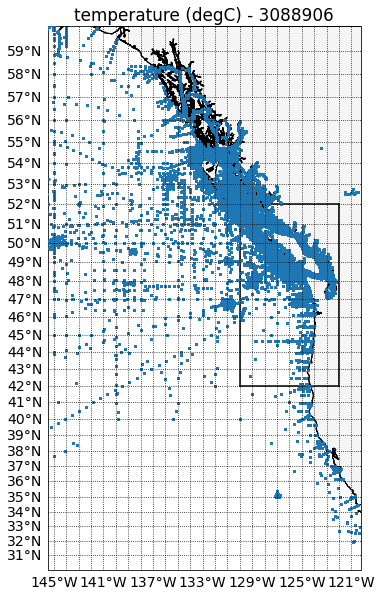

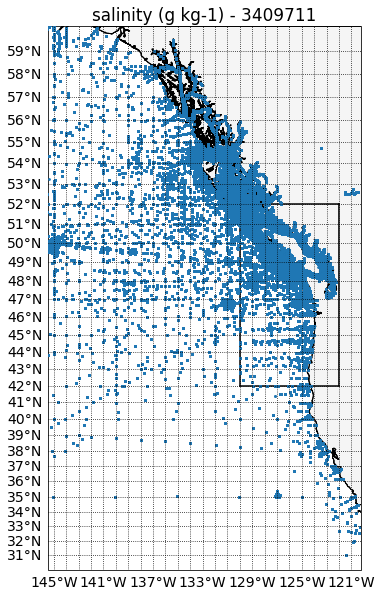

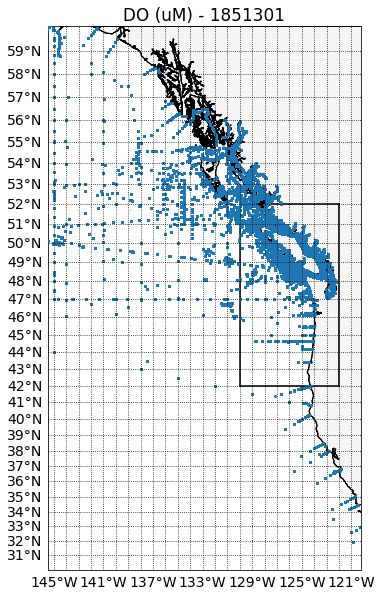

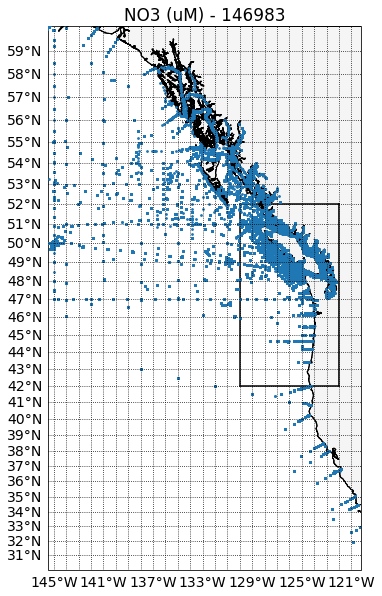

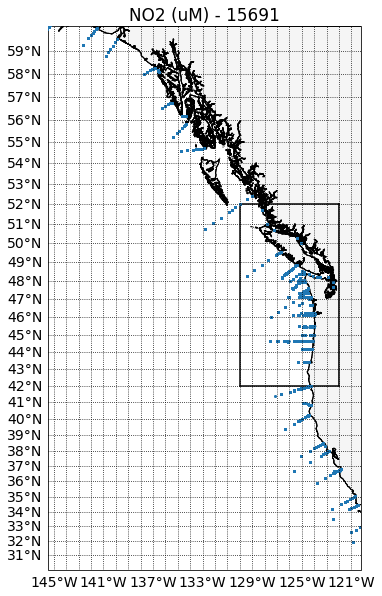

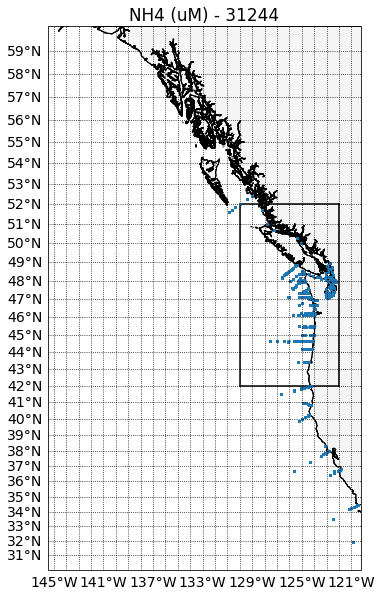

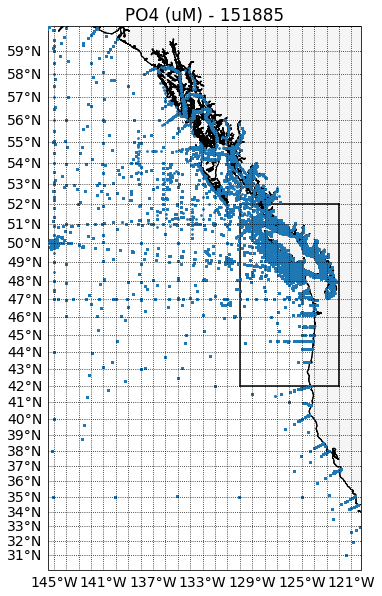

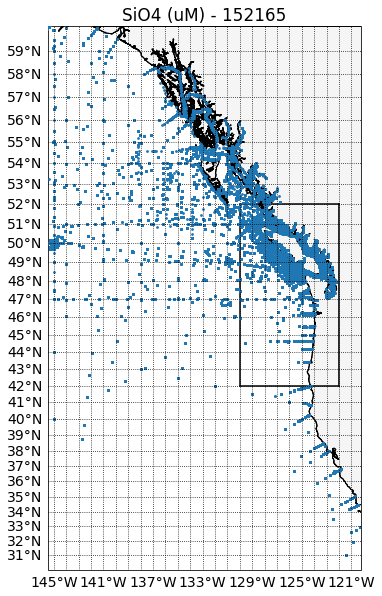

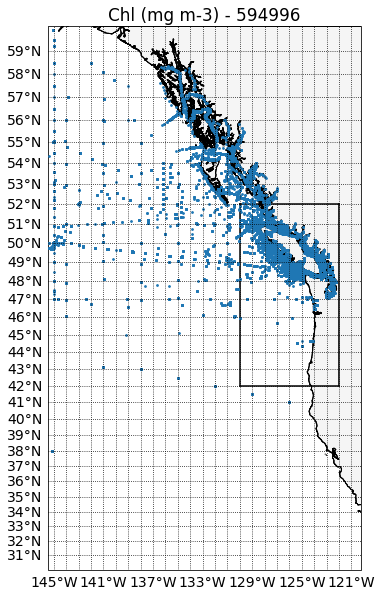

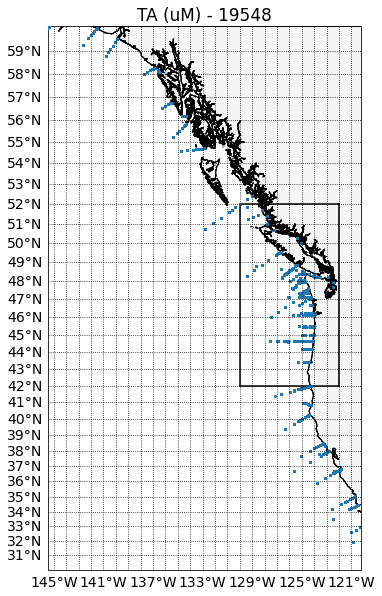

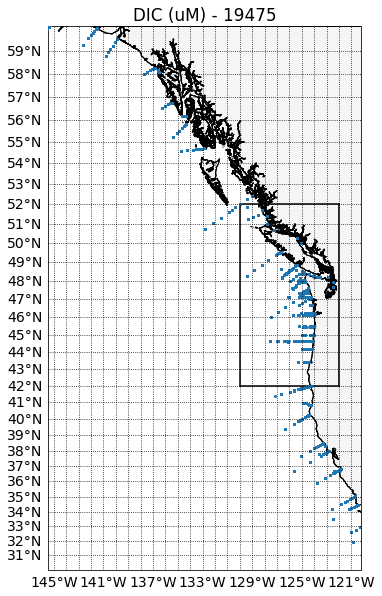

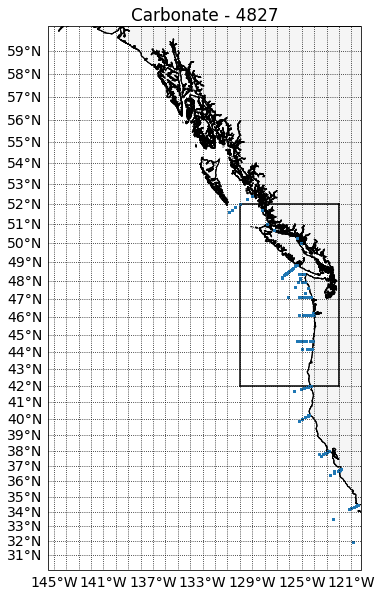

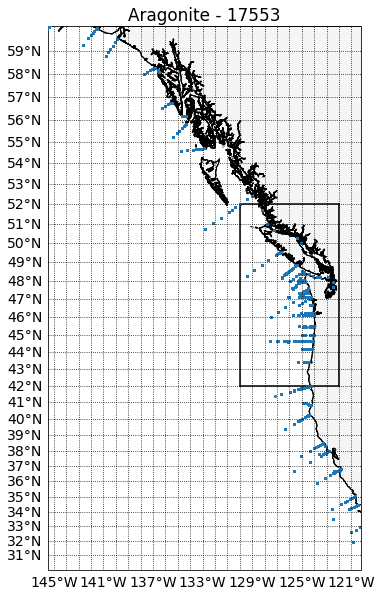

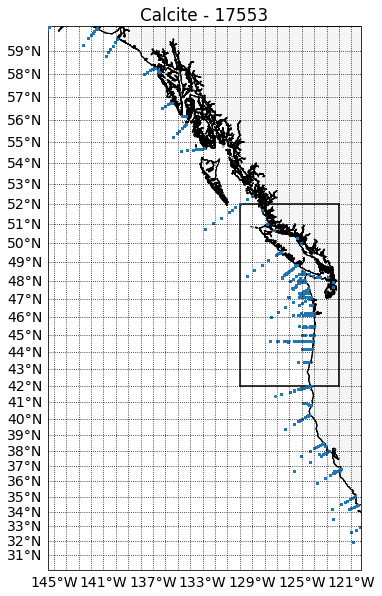

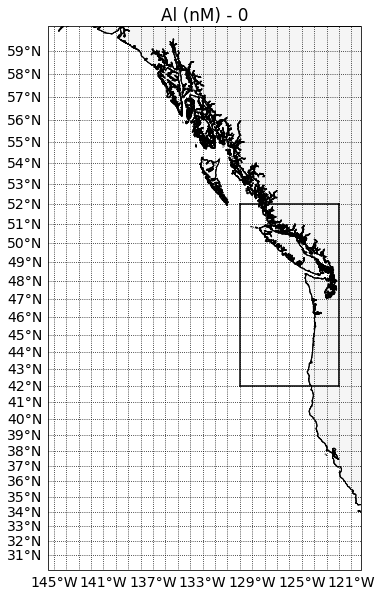

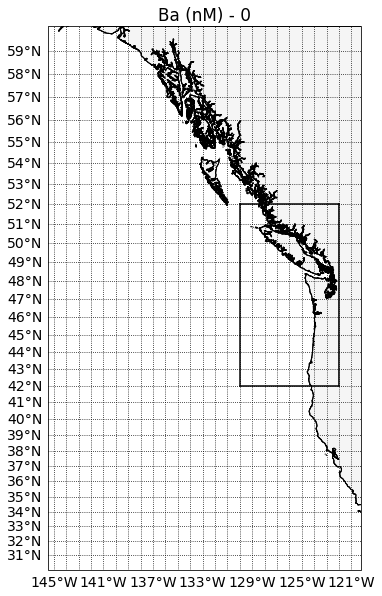

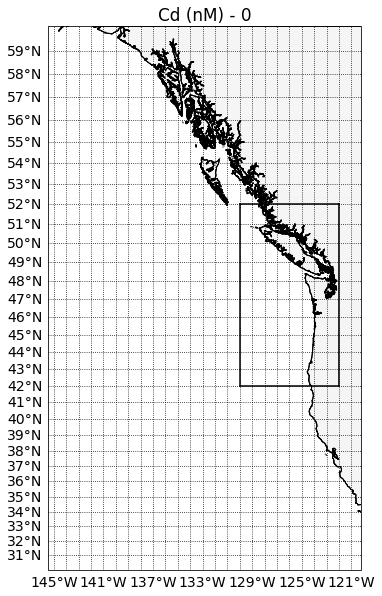

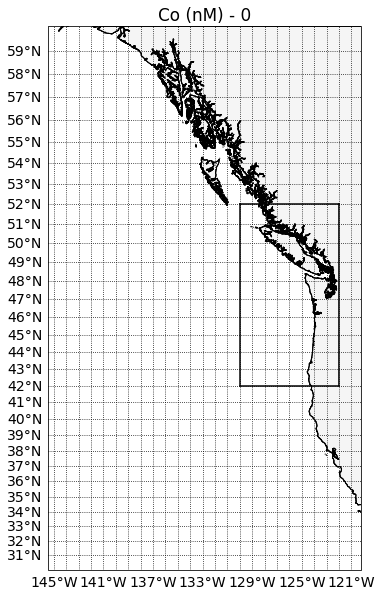

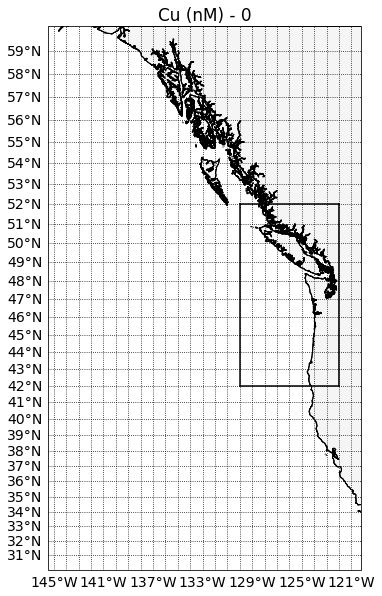

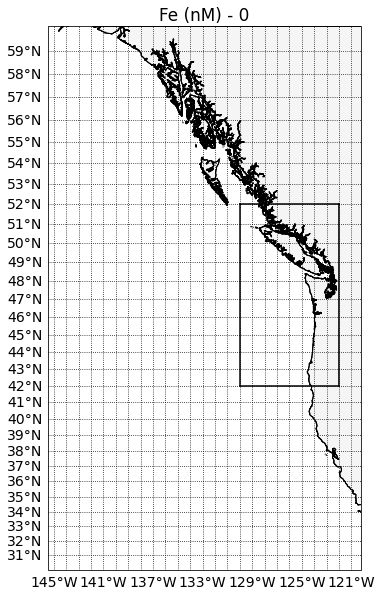

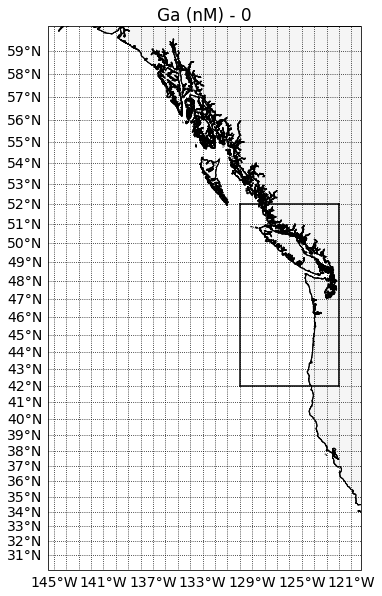

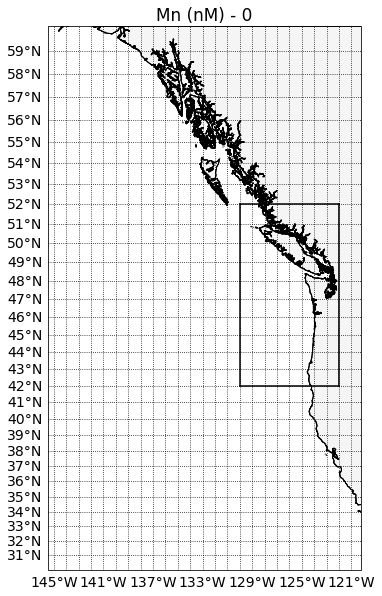

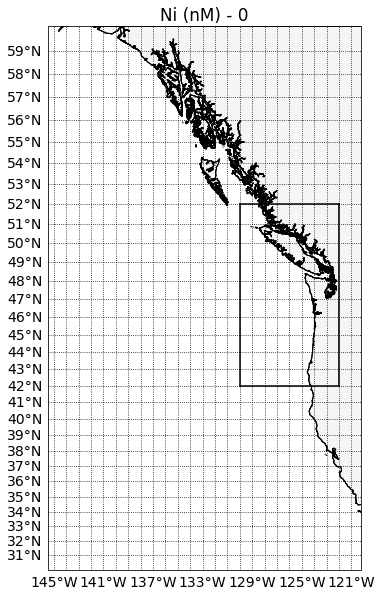

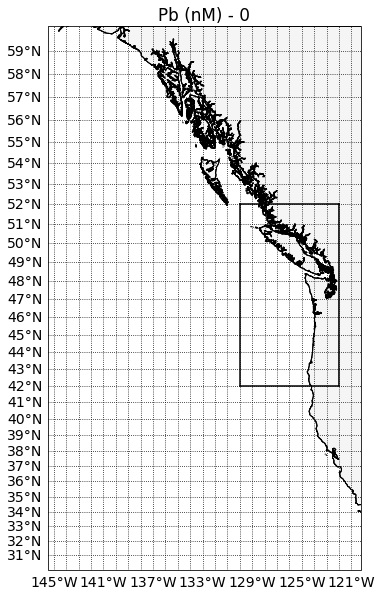

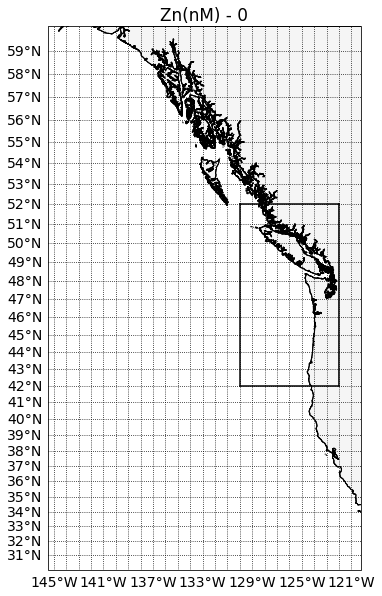

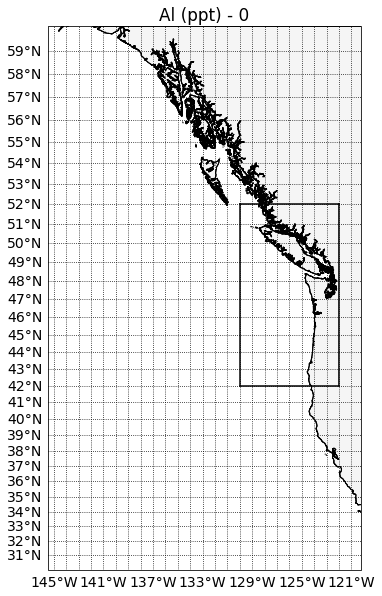

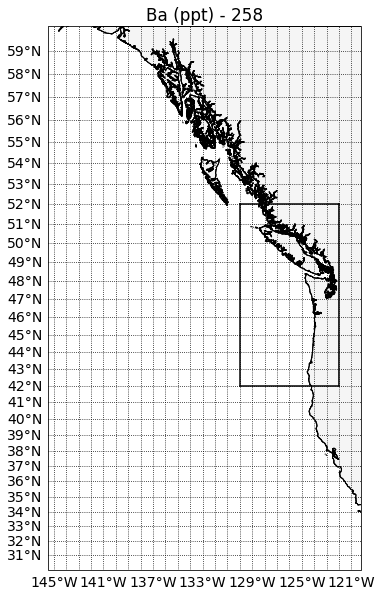

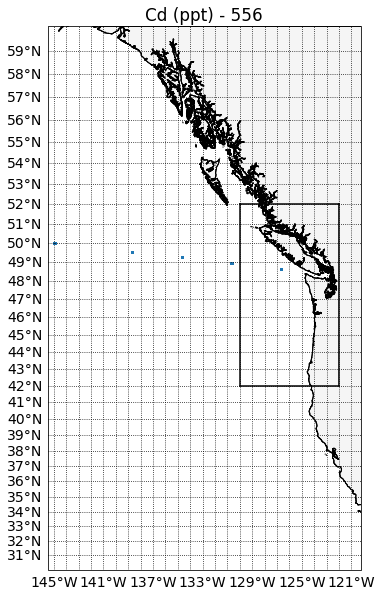

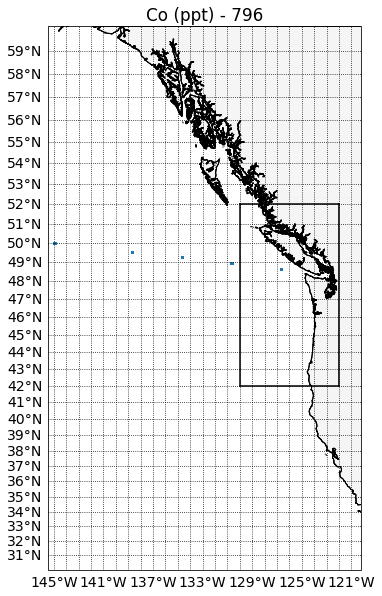

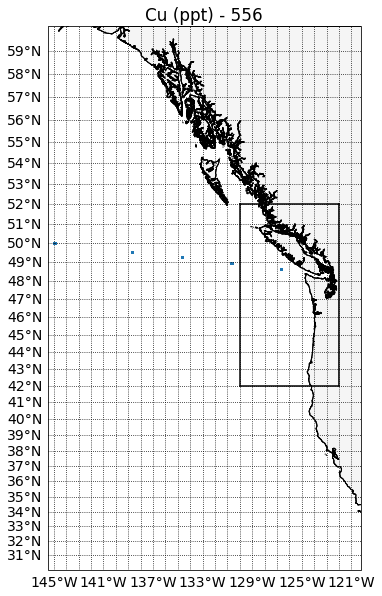

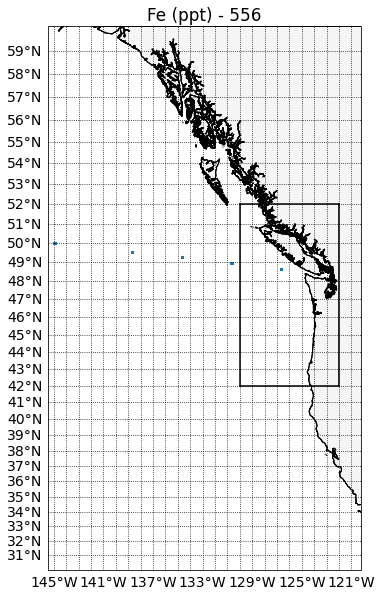

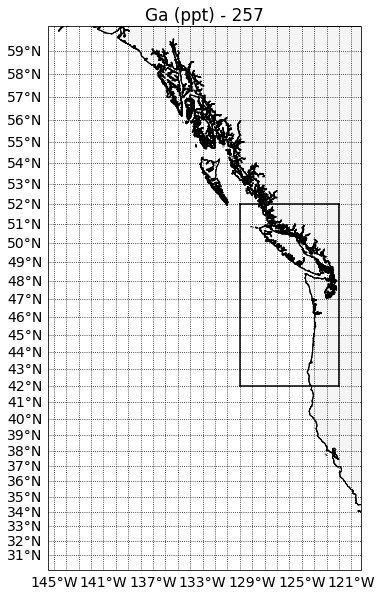

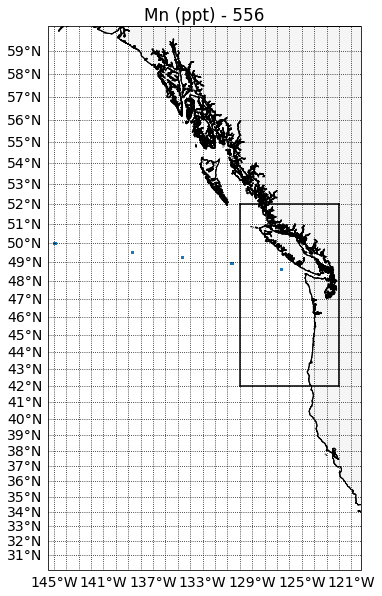

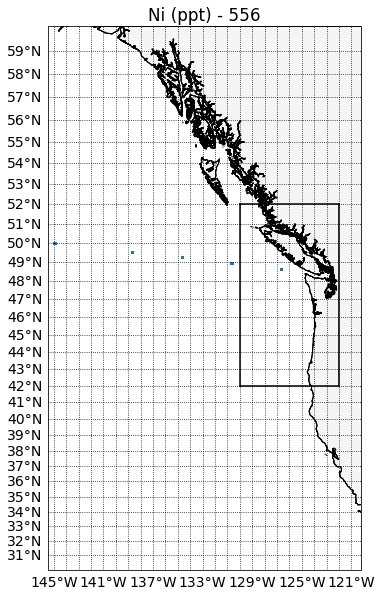

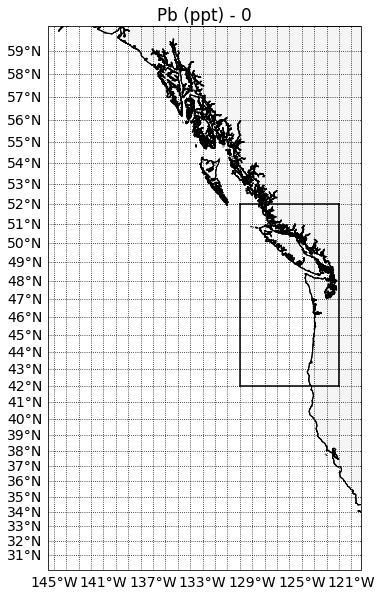

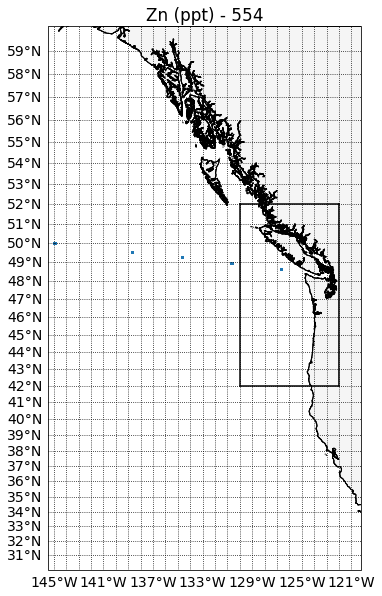

In [36]:
grid = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/LiveOcean/grid.nc')

for tracer in columns_to_count:
    # Increase font size
    plt.rcParams['font.size'] = 14

    # Make plot area
    xlim, ylim = [-145.5, -120.2], [30, 60]
    fig, ax = plt.subplots(figsize=(8, 10), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})
    ax.set_extent(xlim + ylim)

    # Draw coastline
    ax.add_feature(feature.GSHHSFeature('full', facecolor='whitesmoke', zorder=2))
    ax.add_feature(feature.GSHHSFeature('full', edgecolor='k', zorder=4))

    # Add gridlines
    xlocs, ylocs = [np.arange(np.floor(l[0]), np.ceil(l[1])+1) for l in [xlim, ylim]]
    gl = ax.gridlines(linestyle=":", color='k', draw_labels=True, xlocs=xlocs, ylocs=ylocs, zorder=8)
    gl.xformatter, gl.yformatter = LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    gl.top_labels, gl.right_labels = False, False

    # Draw box
    ax.plot(grid.lon_rho[:,0], grid.lat_rho[:,0], 'k-', zorder=6, transform=crs.PlateCarree())
    ax.plot(grid.lon_rho[:,-1], grid.lat_rho[:,-1], 'k-', zorder=6, transform=crs.PlateCarree())
    ax.plot(grid.lon_rho[-1,:], grid.lat_rho[-1,:], 'k-', zorder=6, transform=crs.PlateCarree())
    ax.plot(grid.lon_rho[0,:], grid.lat_rho[0,:], 'k-', zorder=6, transform=crs.PlateCarree())

    # add points
    ax.scatter(ob['longitude (degrees_east)'][~np.isnan(ob[tracer])], ob['latitude (degrees_north)'][~np.isnan(ob[tracer])], s=3, transform=crs.PlateCarree(),zorder=7)

    title = "{} - {}".format(tracer,np.sum(~np.isnan(ob[tracer])))
    ax.set_title(title)

In [37]:
set(ob.source)

{'GEOTRACES',
 'NCEI Coastal',
 'NCEI PNW',
 'NCEI PNW, GEOTRACES',
 'NHL',
 'OCNMS',
 'department of ecology',
 'ios bottle',
 'ios bottle, GEOTRACES',
 'ios bottle, NCEI PNW',
 'ios ctd profiles',
 'ios ctd profiles, NCEI PNW',
 'ios ctd profiles, ios bottle',
 'ios ctd profiles, ios bottle, GEOTRACES',
 'ios ctd profiles, ios bottle, NCEI PNW',
 'ios mooring',
 'ios mooring, ios bottle',
 'ios mooring, ios ctd profiles',
 'ios mooring, ios ctd profiles, ios bottle',
 'onc',
 'ooi'}

In [38]:
for tracer in columns_to_count:
    print(tracer)
    print(set(ob.source[~np.isnan(ob[tracer])]))
    print("\n")

temperature (degC)
{'GEOTRACES', 'ios ctd profiles, ios bottle, GEOTRACES', 'OCNMS', 'ios mooring, ios ctd profiles, ios bottle', 'ios bottle', 'ios ctd profiles, ios bottle, NCEI PNW', 'ios mooring', 'ios mooring, ios ctd profiles', 'NHL', 'ios ctd profiles', 'department of ecology', 'NCEI PNW, GEOTRACES', 'ooi', 'ios bottle, GEOTRACES', 'ios mooring, ios bottle', 'ios bottle, NCEI PNW', 'ios ctd profiles, NCEI PNW', 'onc', 'ios ctd profiles, ios bottle', 'NCEI PNW', 'NCEI Coastal'}


salinity (g kg-1)
{'GEOTRACES', 'ios ctd profiles, ios bottle, GEOTRACES', 'OCNMS', 'ios mooring, ios ctd profiles, ios bottle', 'ios bottle', 'ios ctd profiles, ios bottle, NCEI PNW', 'ios mooring', 'ios mooring, ios ctd profiles', 'NHL', 'ios ctd profiles', 'department of ecology', 'NCEI PNW, GEOTRACES', 'ooi', 'ios bottle, GEOTRACES', 'ios mooring, ios bottle', 'ios bottle, NCEI PNW', 'ios ctd profiles, NCEI PNW', 'onc', 'ios ctd profiles, ios bottle', 'NCEI PNW', 'NCEI Coastal'}


DO (uM)
{'GEOTRACES

In [41]:
ob.to_csv('/data/rbeutel/obs/PNW_obs_compiled.csv')